### Demo for SHIC: Shape-image correspondences with No keypoint supervision

This notebook does not need a GPU, runs well on a CPU

In [2]:
# Imports

import os
import numpy as np
import trimesh as tm
from src.model import DinoV2
from src.shape_model import CSE
from PIL import Image, ImageDraw
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import hashlib

In [5]:
# Load some weights

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
models = {}
for class_name in ['bear', 'horse', 'elephant']:
    print(f'Loading model weights for {class_name}')
    models[class_name] = {
        'image_encoder': DinoV2(16),
        'cse': CSE(class_name=class_name, num_basis=64, device=device)
    }
    models[class_name]['image_encoder'].load_state_dict(torch.load(f'./models/weights/{class_name}.pth', map_location=device))
    models[class_name]['cse'].load_state_dict(torch.load(f'./models/weights/{class_name}_cse.pth', map_location=device))
    models[class_name]['cse'].functional_basis = torch.load(f'./models/weights/{class_name}_lbo.pth', map_location=device)
    
    models[class_name]['image_encoder'] = models[class_name]['image_encoder'].to(device)
    models[class_name]['cse'] = models[class_name]['cse'].to(device)
    models[class_name]['cse'].functional_basis = models[class_name]['cse'].functional_basis.to(device)
    models[class_name]['cse'].weight_matrix = models[class_name]['cse'].weight_matrix.to(device)

    models[class_name]['shape_feats'] = models[class_name]['cse']().to(device)

# Convert PIL image to a format your model expects (e.g., torch.Tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

cached_features = {'bear': {}, 'horse': {}, 'elephant': {}}
sphere_verts_ = torch.load(f'./models/weights/sphere_verts.pth', map_location=device)
sphere_faces_ = torch.load(f'./models/weights/sphere_faces.pth', map_location=device)

Loading model weights for bear


Using cache found in /users/suny/.cache/torch/hub/facebookresearch_dinov2_main


Loading model weights for horse


Using cache found in /users/suny/.cache/torch/hub/facebookresearch_dinov2_main


Loading model weights for elephant


Using cache found in /users/suny/.cache/torch/hub/facebookresearch_dinov2_main


In [6]:
# Helper functions

def image_hash(image):
    """Generate a hash for an image."""
    image_bytes = image.tobytes()
    hash_function = hashlib.sha256()
    hash_function.update(image_bytes)
    return hash_function.hexdigest()

def center_crop(img):
    """
    Center crops an image to the target size of 224x224.
    """
    width, height = img.size   # Get dimensions
    # Calculate the target size for center cropping
    target_size = min(width, height)
    
    # Calculate the coordinates for center cropping
    left = (width - target_size) // 2
    top = (height - target_size) // 2
    right = left + target_size
    bottom = top + target_size
    
    # Perform center cropping
    cropped_img = img.crop((left, top, right, bottom))
    
    return cropped_img

def draw_point_on_image(image, x_, y_):
    """Draws a red dot on a copy of the image at the specified point."""
    # Make a copy of the image to avoid altering the original
    image_copy = image.copy()
    draw = ImageDraw.Draw(image_copy)
    x, y = x_, y_  # Adjust these based on the actual structure of `point`
    dot_radius = image.size[0] // 40
    # Draw a red dot
    draw.ellipse([(y-dot_radius, x-dot_radius), (y+dot_radius, x+dot_radius)], fill='red')
    
    return image_copy

def rotate_y(vertices, angle_degrees):
    angle_radians = np.radians(angle_degrees)
    rotation_matrix = np.array([
        [np.cos(angle_radians), 0, np.sin(angle_radians)],
        [0, 1, 0],
        [-np.sin(angle_radians), 0, np.cos(angle_radians)]
    ])
    
    # Assuming vertices is a numpy array of shape (N, 3)
    rotated_vertices = np.dot(vertices, rotation_matrix)
    return rotated_vertices

def make_final_mesh(verts, faces, similarities):
    vert_argmax = similarities.argmax(dim=1)
    vertex = verts[vert_argmax]
    color=[255, 0, 0]

    vertex_colors=similarities.transpose(1,0).cpu().detach().numpy()
    # to viridis color map
    vertex_colors = plt.cm.viridis(vertex_colors)[:, 0, :3]

    num_verts_so_far = len(verts)

    
    # Create a sphere mesh

    # Scale and translate the sphere to the desired location and size
    scale_dot = 0.015  # radius of the sphere
    translation = torch.tensor(vertex, device=device).unsqueeze(0)  # desired location

    verts_sphere = sphere_verts_ * scale_dot + translation  # scale and translate vertices
    faces_sphere = sphere_faces_ + num_verts_so_far  # faces are the same

    verts_rgb_sphere = torch.tensor([color], device=device).expand(verts_sphere.shape[0], -1)[None] / 255  # [1, N, 3]


    # verts and all sphere verts
    # concat np arrays verts + verts_sphere.cpu().numpy() (4936,3) (2562,3)
    all_verts = np.concatenate([verts, verts_sphere.cpu().numpy()], axis=0)
    all_faces = np.concatenate([faces, faces_sphere.cpu().numpy()], axis=0)

    all_textures = np.concatenate([vertex_colors, verts_rgb_sphere.cpu().numpy()[0]], axis=0)

    return tm.Trimesh(vertices=all_verts, faces=all_faces, vertex_colors=all_textures)

def process_mesh(image, class_name, x_, y_):
    x_, y_ = x_, y_
    h, w = image.size

    x = torch.tensor(x_ * 224 / w)
    y = torch.tensor(y_ * 224 / h)

    hashed_image = image_hash(image)
    if hashed_image in cached_features[class_name]:
        feats = cached_features[class_name][hashed_image]
    else: 
        image_tensor = transform(image).unsqueeze(0)
        
        # Predict texture
        feats = models[class_name]['image_encoder'](image_tensor.to(device))

        cached_features[class_name][hashed_image] = feats

    # print('feats shape', feats.shape)

    sampled_feats = feats[:, :, x.long(), y.long()]
    similarities = torch.einsum('ik, lk -> il', sampled_feats, models[class_name]['shape_feats'])
    # normalize similarities
    similarities = (similarities - similarities.min()) / (similarities.max() - similarities.min())

    faces =  models[class_name]['cse'].shape['faces'].cpu().numpy().copy()
    verts = models[class_name]['cse'].shape['verts'].cpu().numpy().copy()

    # rotate the shape 235 
    verts = rotate_y(verts, 145)

    mesh = make_final_mesh(verts, faces, similarities)
    
    return mesh

In [13]:
# Select an image

image_path = 'images/mylittlepony.png'
class_name = 'horse' # One of horse, bear, elephant. Works cross-classes too!
image = Image.open(image_path).convert('RGB')

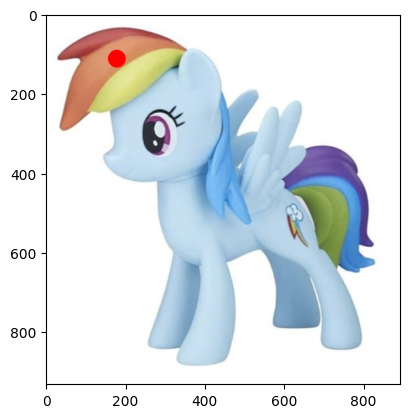

In [14]:
# Seelect a location in the image

loc = [112, 178]
annotated_image = draw_point_on_image(image, loc[0], loc[1])
plt.imshow(annotated_image)

In [15]:
# Predict correspondence and visualise
# The rendering is interactive, so you can click and drag to see the corresponence

prediction_on_mesh = process_mesh(image, class_name, loc[0], loc[1])
prediction_on_mesh.show()
